In [1]:
!pip install -q pandas scikit-learn xgboost shap gradio matplotlib seaborn transformers


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from transformers import pipeline, set_seed


## 📊 Load & Explore Dataset

In [3]:

url = "https://raw.githubusercontent.com/sharmaroshan/Heart-UCI-Dataset/master/heart.csv"
data = pd.read_csv(url)

# Preview the dataset
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Column	Description

age	Age of the patient

sex	Sex (1 = male; 0 = female)

cp	Chest pain type (0–3)

trestbps	Resting blood pressure

chol	Serum cholesterol (mg/dl)

fbs	Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

restecg	Resting electrocardiographic results (0–2)

thalach	Maximum heart rate achieved

exang	Exercise-induced angina (1 = yes; 0 = no)

oldpeak	ST depression induced by exercise

slope	Slope of peak exercise ST segment

ca	Number of major vessels (0–3) colored by fluoroscopy

thal	Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)

target	Target variable (1 = presence of heart disease; 0 = absence)

# Basic Info

In [4]:
# Shape of the dataset
print("Shape:", data.shape)

# Data types and null values
print(data.info())
print(data.isnull().sum())


Shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
d

# Statistical Summary

In [5]:
# Descriptive statistics
data.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Class Distribution (Target Variable)

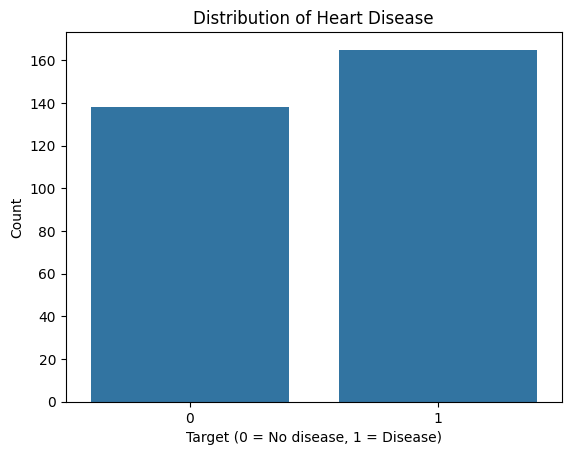

In [6]:
# Distribution of the target variable
sns.countplot(x='target', data=data)
plt.title("Distribution of Heart Disease")
plt.xlabel("Target (0 = No disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()


Interpretation:

Target = 0 (No disease): ~140 patients

Target = 1 (Has disease): ~165 patients

This indicates:

Slight class imbalance, with more patients having heart disease than not.

# Correlation Heatmap

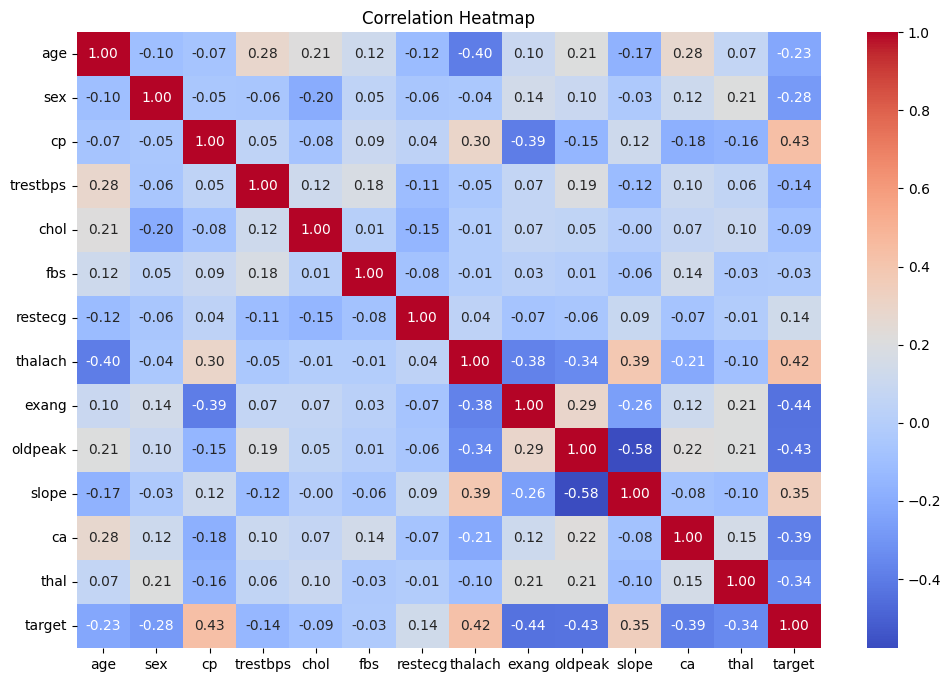

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


**Key Correlations with Target (Heart Disease)**

Feature: ... Correlation with target ...	             Interpretation

cp	... +0.43	... Higher chest pain type is positively associated with heart disease.

thalach	... +0.42	... Higher max heart rate achieved is associated with heart disease.

slope	... +0.35	... Slope of ST segment is relevant.

sex	...  -0.28	... Being male (1) is negatively associated with disease (men are more likely to have it).

exang	... -0.43	... Exercise-induced angina is negatively correlated with target (presence of angina suggests disease).

ca	... -0.39	... More major vessels visible = lower chance of heart disease.

thal	... -0.34	... Certain thalassemia types are linked with heart disease.

oldpeak	... -0.43	... Higher ST depression = more likely to have disease.


**Insights:**

Features like cp, thalach, slope are positively correlated with heart disease presence.

exang, oldpeak, ca, thal are negatively correlated, meaning higher values reduce the chance of the target being 1.

chol, fbs, and restecg show weak correlation with the target and might be dropped or down-weighted unless domain knowledge suggests otherwise.

# Distribution of Key Features

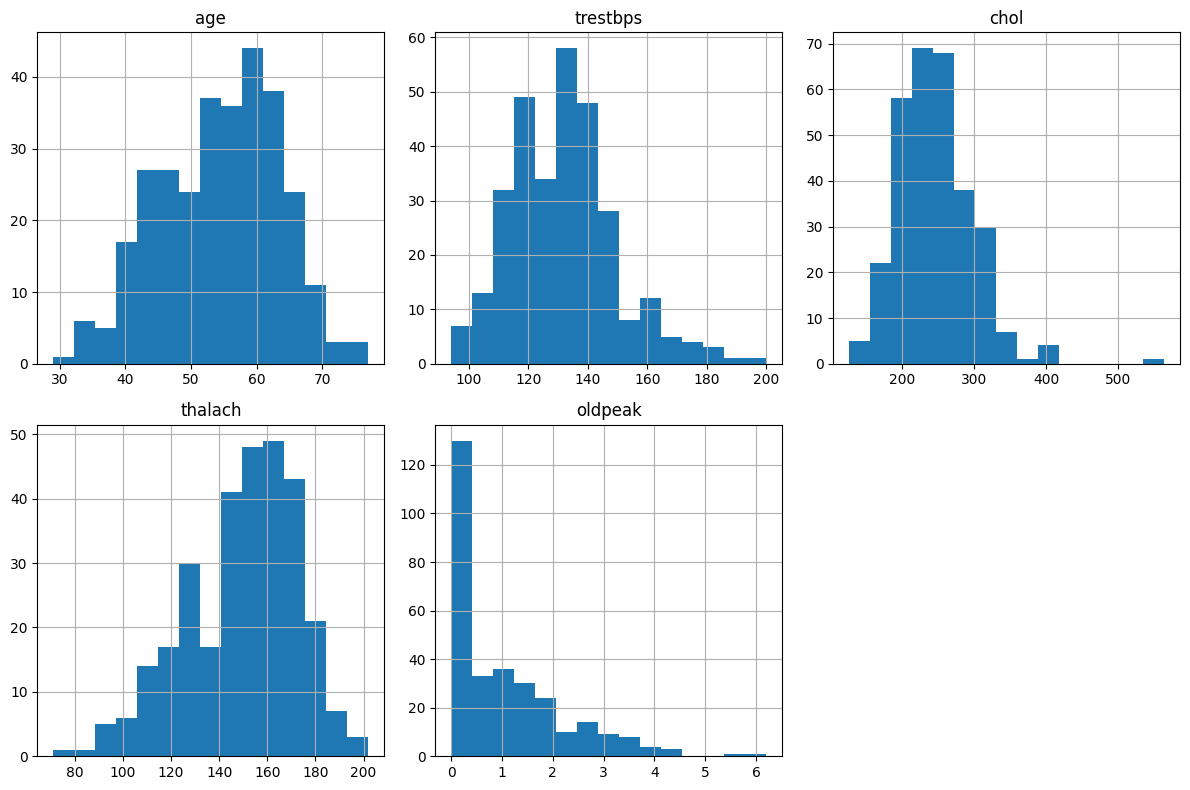

In [8]:
# Histograms of key continuous features
data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].hist(bins=15, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()


**Feature Distribution Insights**

Feature	>>> Distribution Shape	>>> Observations

age	>>> Normal-like (centered ~55–60)	>>> Most patients are in their 50s and 60s.

trestbps	>>> Slightly right-skewed	>>> Majority have resting BP between 120–140 mmHg.

chol	>>> Right-skewed with outliers	>>> Cholesterol mostly between 200–300, with some high outliers (over 500).

thalach	>>> Slight left skew	>>> Most patients’ max heart rate is between 130–170 bpm.

oldpeak	>>> Highly right-skewed	>>> ST depression mostly low (0–1), a few patients have very high values (3–6).



**Implications:**

Considering log-scaling chol and oldpeak to reduce skewness and improve model learning.

Outliers in cholesterol may need to be treated (e.g. capping or transformation).

No need to scale age, trestbps, thalach unless using distance-based models (e.g. KNN, SVM).



# Boxplots for Outlier Detection

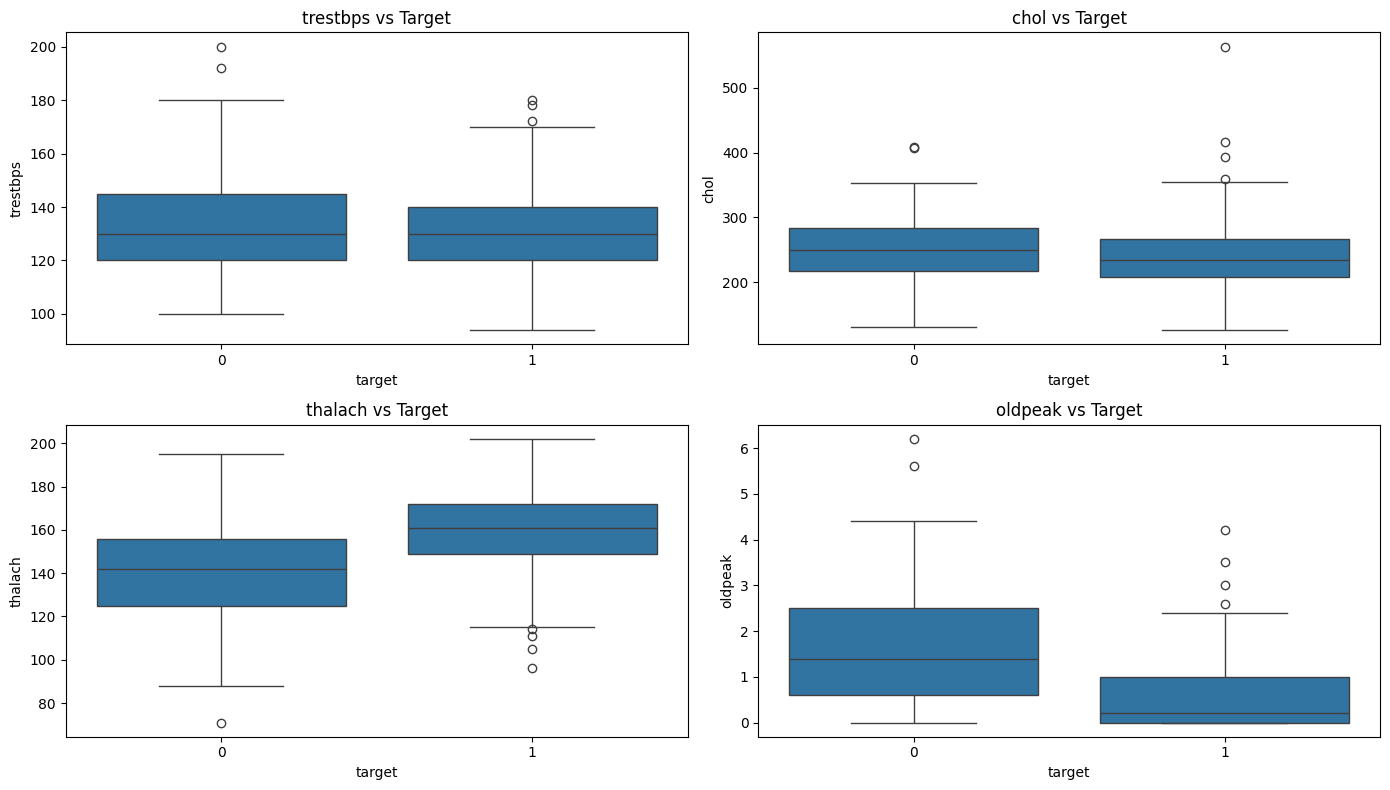

In [9]:
# Boxplots to visualize outliers
plt.figure(figsize=(14, 8))
for i, col in enumerate(['trestbps', 'chol', 'thalach', 'oldpeak']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='target', y=col, data=data)
    plt.title(f"{col} vs Target")
plt.tight_layout()
plt.show()



**Boxplot Interpretation by Feature**
Feature	>>> Observation

trestbps >>> (Resting BP)	Median BP is slightly lower in heart disease patients, but overall similar distribution.

chol (Cholesterol)	>>> Wide spread in both groups, with outliers — not strongly discriminative on its own.

thalach (Max Heart Rate)	>>> Significantly higher in patients with heart disease — strong inverse relation.

oldpeak (ST depression)	>>> Clearly higher in patients without heart disease — supports correlation (−0.43) with target.


**Summary of Findings So Far:**

Most predictive features so far:
✅ thalach, oldpeak, cp, slope, ca, thal

Less informative or noisy features:
⚠️ chol, fbs, restecg — low correlation, high variance, and similar medians between target groups

# Categorical Features vs Target

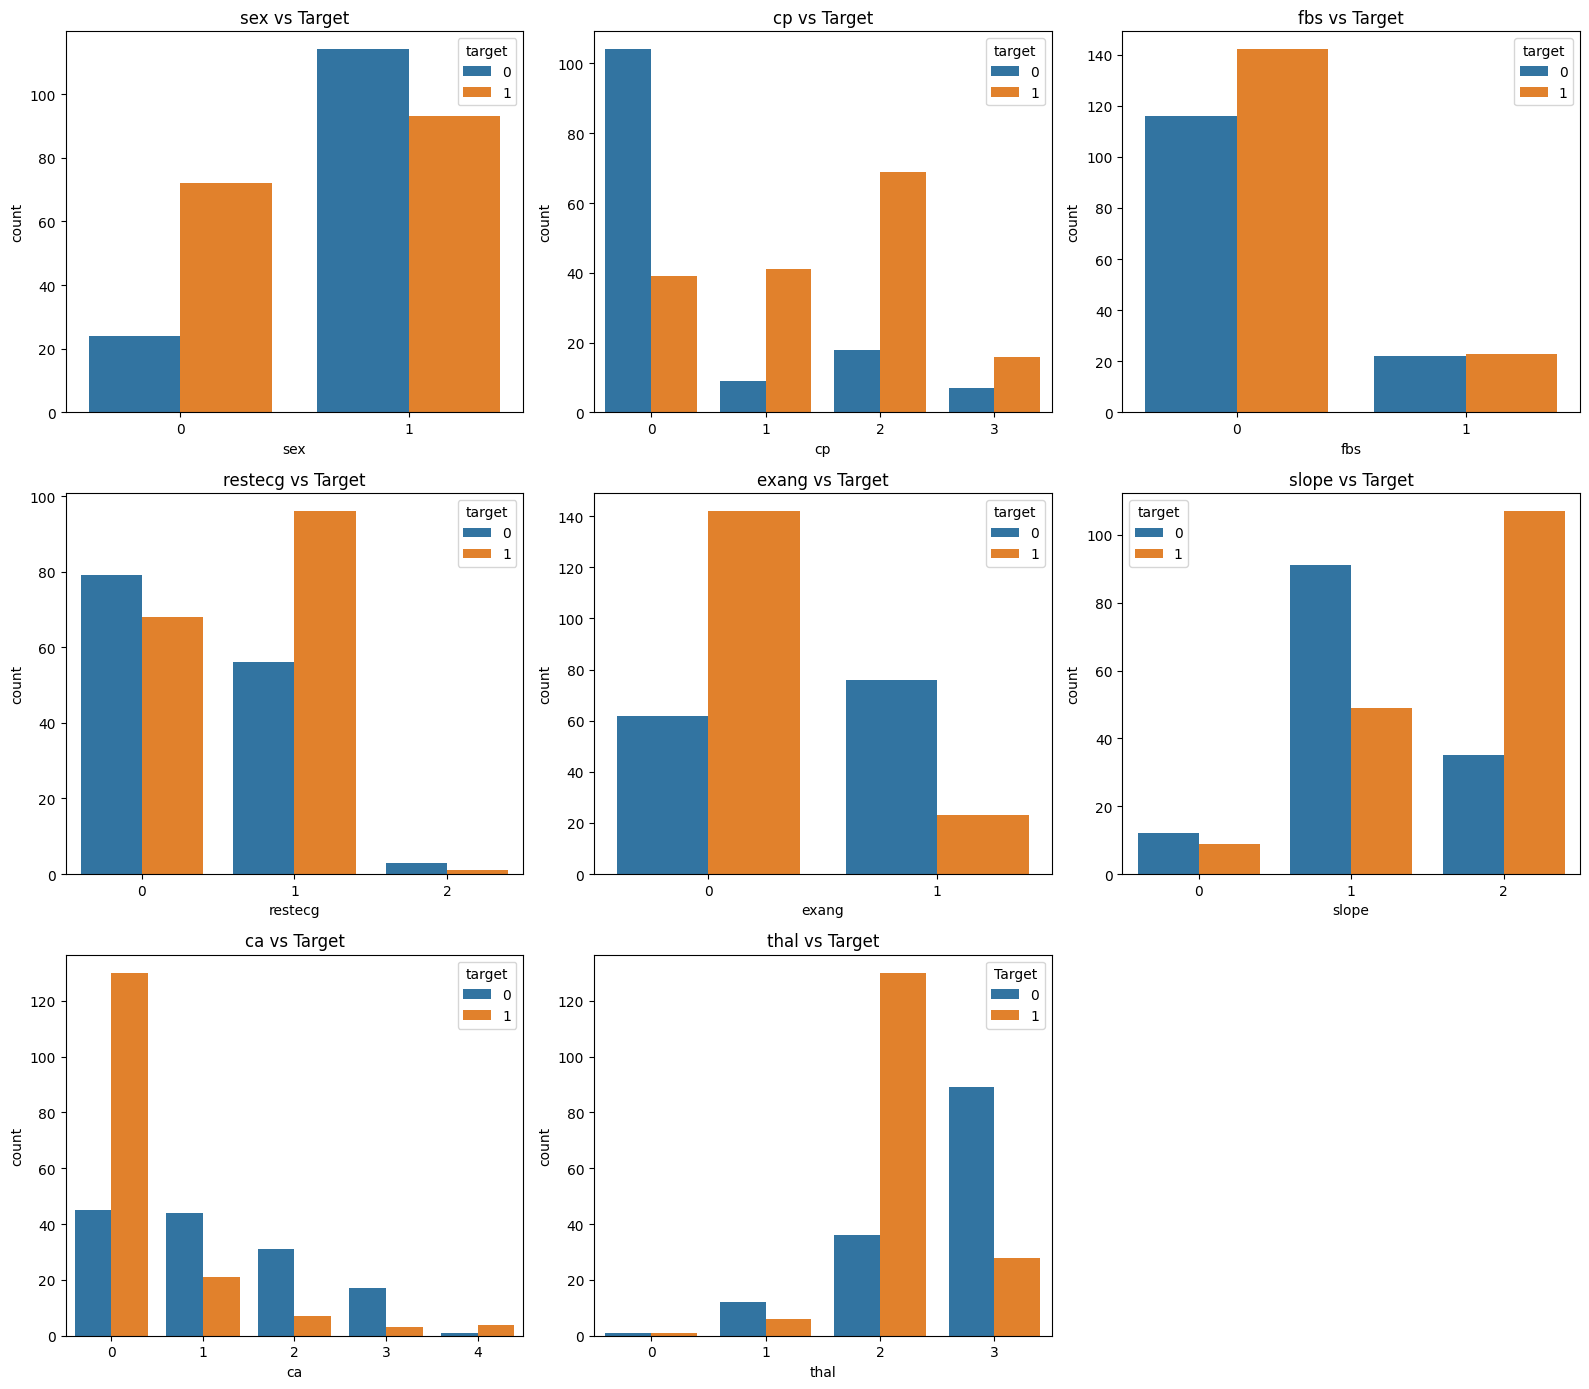

In [10]:
# Count plots for categorical variables
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

plt.figure(figsize=(16, 14))
for i, col in enumerate(cat_features):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='target', data=data)
    plt.title(f"{col} vs Target")
plt.legend(title='Target')
plt.tight_layout()
plt.show()


**Insights from Categorical Features vs Target**

Feature	>>> Interpretation

sex	Males >>> (1) dominate the dataset, and more males are diagnosed with heart disease.

cp (chest pain type)	>>> Type 0 is strongly associated with target = 0, while type 2 and 3 are mostly target = 1 → high predictive power.

fbs	>>> Not strongly discriminative. Similar counts in both classes.

restecg	>>> Value 1 (some ECG abnormality) more associated with disease.

exang	>>> No exercise-induced angina (0) is associated with disease → supports negative correlation.

slope	>>> Slope 2 is most indicative of disease, slope 1 of non-disease.

ca	>>> Higher number of major vessels (3–4) associated with no disease.

thal	>>> Thal 2 and 3 are associated with disease, Thal 1 with no disease.

# Identify Feature Types



In [11]:
# Basic types
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target_col = 'target'

# Advanced Feature Engineering

In [12]:
# Feature: cholesterol-to-age ratio
data['chol_per_age'] = data['chol'] / data['age']

# Feature: heart rate reserve (simplified version)
data['hr_reserve'] = 220 - data['age'] - data['thalach']

# Feature: normalized ST depression
data['oldpeak_log'] = np.log1p(data['oldpeak'])

# Feature: cholesterol x resting BP (interaction)
data['chol_trestbps_interaction'] = data['chol'] * data['trestbps']


# One-Hot Encode Categorical Features

In [13]:
# One-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


# Feature Scaling (StandardScaler)

In [14]:
from sklearn.preprocessing import StandardScaler

# Identify new numerical columns (after adding engineered features)
numerical_cols_extended = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                           'chol_per_age', 'hr_reserve', 'oldpeak_log', 'chol_trestbps_interaction']

scaler = StandardScaler()
data_encoded[numerical_cols_extended] = scaler.fit_transform(data_encoded[numerical_cols_extended])

data_encoded.head()

,age,trestbps,chol,thalach,oldpeak,target,chol_per_age,hr_reserve,oldpeak_log,chol_trestbps_interaction,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,-0.844887,-0.428493,1.192005,0.147025,...,False,False,False,False,False,False,False,True,False,False
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,1.928563,-0.952976,1.784504,-0.003012,...,False,False,False,False,False,False,False,False,True,False
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1,0.313335,-0.428493,0.583653,-0.701237,...,False,False,True,False,False,False,False,False,True,False
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,-0.377069,-1.429779,0.034085,-0.491069,...,False,False,True,False,False,False,False,False,True,False
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1,1.433216,-0.762255,-0.190919,1.162254,...,True,False,True,False,False,False,False,False,True,False


# Train-Test Split

In [15]:
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Models

# Logistic Regression

In [16]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))
print("ROC AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

ROC AUC: 0.9004329004329004


# Random Forest

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.74      0.85      0.79        33

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61

ROC AUC: 0.8782467532467533


# XGBoost

In [18]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))
print("ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:18:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.71      0.61      0.65        28
           1       0.70      0.79      0.74        33

    accuracy                           0.70        61
   macro avg       0.71      0.70      0.70        61
weighted avg       0.71      0.70      0.70        61

ROC AUC: 0.8452380952380952


# Compile Results in a Table

In [19]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
    ]
})

print(results.sort_values(by='ROC AUC', ascending=False))


                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.868852  0.900433
1        Random Forest  0.754098  0.878247
2              XGBoost  0.704918  0.845238


# Set Up Cross-Validation

In [20]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Hyperparameter Grids

In [21]:
# Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5]
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}


# Run GridSearchCV

In [22]:
# Logistic Regression
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=cv, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

# Random Forest
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=cv, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

# XGBoost
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=cv, scoring='roc_auc')
xgb_grid.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='roc_auc')

# Evaluate Best Models

In [23]:
models = {
    "Logistic Regression": lr_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    acc = accuracy_score(y_test, y_pred)
    results.append([name, acc, roc])

# Results as DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC AUC'])
results_df = results_df.sort_values(by='ROC AUC', ascending=False)
print(results_df)

                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.868852  0.900433
1        Random Forest  0.786885  0.883117
2              XGBoost  0.721311  0.854978


# View Best Hyperparameters

In [24]:
print("Best Params - Logistic Regression:", lr_grid.best_params_)
print("Best Params - Random Forest:", rf_grid.best_params_)
print("Best Params - XGBoost:", xgb_grid.best_params_)

Best Params - Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Params - Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best Params - XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


# Voting Ensemble Classifier

# Initialize Models with Best Params

In [25]:
from sklearn.ensemble import VotingClassifier

# Best estimators from grid search
lr_best = LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=1000)
rf_best = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
xgb_best = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                         use_label_encoder=False, eval_metric='logloss', random_state=42)

# Build the Voting Classifier

In [26]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_best),
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='soft'  # Use probabilities for ROC AUC support
)


# Fit and Evaluate Ensemble

In [27]:
voting_clf.fit(X_train, y_train)

# Predictions & Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

voting_preds = voting_clf.predict(X_test)
voting_probs = voting_clf.predict_proba(X_test)[:, 1]

voting_accuracy = accuracy_score(y_test, voting_preds)
voting_roc_auc = roc_auc_score(y_test, voting_probs)

print("Voting Classifier Results:")
print(classification_report(y_test, voting_preds))
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"ROC AUC: {voting_roc_auc:.4f}")


Voting Classifier Results:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61

Accuracy: 0.7869
ROC AUC: 0.8701


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Final Model Comparison Table

In [28]:
results_df.loc[len(results_df.index)] = ['Voting Ensemble', voting_accuracy, voting_roc_auc]
results_df = results_df.sort_values(by='ROC AUC', ascending=False)
print(results_df.reset_index(drop=True))


                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.868852  0.900433
1        Random Forest  0.786885  0.883117
2      Voting Ensemble  0.786885  0.870130
3              XGBoost  0.721311  0.854978


# Key Takeaways

Logistic Regression is still the top model in both accuracy and AUC.

Random Forest has a better ROC AUC than Voting, but lower accuracy, indicating:

It's slightly better at ranking probabilities correctly (AUC),

But more prone to misclassification than the ensemble.

Voting Ensemble is in the middle — stable and safe, but not optimal.

XGBoost underperforms in this setup — perhaps due to dataset size or lack of boosting power here.

# Stacked Generalization (StackingClassifier)

In [29]:
from sklearn.ensemble import StackingClassifier


# Base models with best params
lr = LogisticRegression(C=1, penalty='l2', solver='lbfgs', max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                    use_label_encoder=False, eval_metric='logloss', random_state=42)



# Use Logistic Regression as the meta-learner
stack_model = StackingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

stack_model.fit(X_train, y_train)
stack_preds = stack_model.predict(X_test)
stack_probs = stack_model.predict_proba(X_test)[:, 1]

stack_acc = accuracy_score(y_test, stack_preds)
stack_auc = roc_auc_score(y_test, stack_probs)

print("Stacking Classifier Results:")
print(classification_report(y_test, stack_preds))
print(f"Accuracy: {stack_acc:.4f}")
print(f"ROC AUC: {stack_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacking Classifier Results:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Accuracy: 0.8361
ROC AUC: 0.8939


# Weighted Voting Classifier

In [30]:
# Assign higher weight to Logistic Regression based on previous results
weighted_voting_model = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[3, 2, 1]  # prioritize logistic > RF > XGB
)

weighted_voting_model.fit(X_train, y_train)
wvote_preds = weighted_voting_model.predict(X_test)
wvote_probs = weighted_voting_model.predict_proba(X_test)[:, 1]

wvote_acc = accuracy_score(y_test, wvote_preds)
wvote_auc = roc_auc_score(y_test, wvote_probs)

print("Weighted Voting Classifier Results:")
print(classification_report(y_test, wvote_preds))
print(f"Accuracy: {wvote_acc:.4f}")
print(f"ROC AUC: {wvote_auc:.4f}")


Weighted Voting Classifier Results:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61

Accuracy: 0.8033
ROC AUC: 0.8831


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Add to Results Table

In [31]:
results_df.loc[len(results_df.index)] = ['Stacking Ensemble', stack_acc, stack_auc]
results_df.loc[len(results_df.index)] = ['Weighted Voting Ensemble', wvote_acc, wvote_auc]

results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print(results_df)


                      Model  Accuracy   ROC AUC
0       Logistic Regression  0.868852  0.900433
1         Stacking Ensemble  0.836066  0.893939
2  Weighted Voting Ensemble  0.803279  0.883117
3             Random Forest  0.786885  0.883117
4           Voting Ensemble  0.786885  0.870130
5                   XGBoost  0.721311  0.854978


# Interpretation




✅ Logistic Regression remains the best model, offering both the highest accuracy and AUC. Simple, interpretable, and effective.

🔄 Stacking Ensemble is competitive, with a slightly lower AUC but strong performance — ideal if you're optimizing for ensemble robustness.

🎯 Weighted Voting improved upon standard voting but didn't outperform stacking or LR.

❌ XGBoost underperformed — possibly due to dataset size or overfitting.

# Recommendations

| Goal                          | Best Model                            |
| ----------------------------- | ------------------------------------- |
| Interpretability + simplicity | **Logistic Regression**               |
| Ensemble stability            | **Stacking Ensemble**                 |
| Balanced ensembling           | **Weighted Voting**                   |
| Model experimentation         | Try **LightGBM** or **catboost** next |


## Resposible AI


In [32]:

# 👇 Ensure the model is trained BEFORE SHAP
xgb_model = xgb_best  # Or define it as shown below if needed

# If not already defined:
# from xgboost import XGBClassifier
# xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
#                           use_label_encoder=False, eval_metric='logloss', random_state=42)

# ✅ Train the model
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

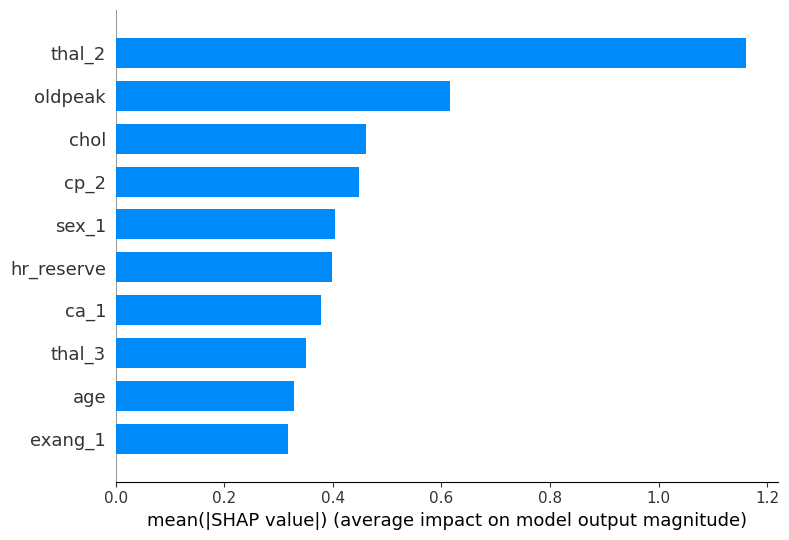

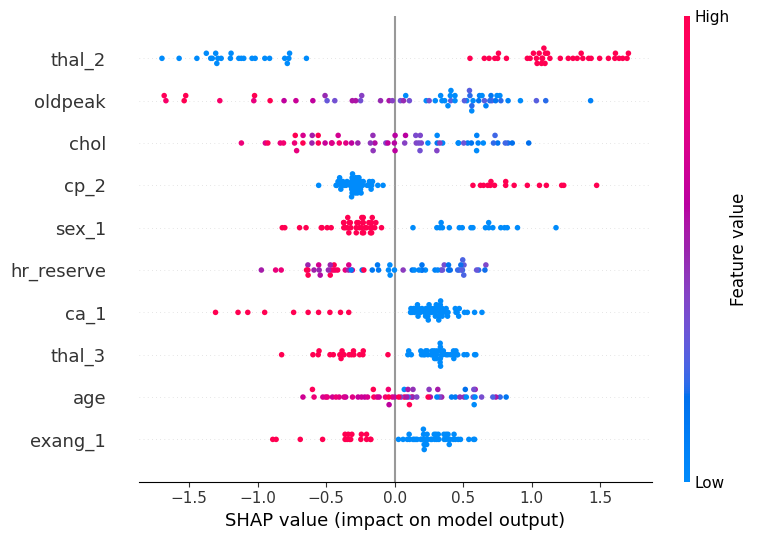

In [33]:
# ✅ Create SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# ✅ Compute SHAP values
shap_values = explainer.shap_values(X_test)

# ✅ Global feature importance plots
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
shap.summary_plot(shap_values, X_test, max_display=10)

In [34]:
# ✅ Directly get all feature names from your DataFrame
all_feature_names = data_encoded.drop('target', axis=1).columns.tolist()

# 🔍 Index mapping for SHAP or inspection
for i, name in enumerate(all_feature_names):
    print(f"Feature {i} → {name}")


Feature 0 → age
Feature 1 → trestbps
Feature 2 → chol
Feature 3 → thalach
Feature 4 → oldpeak
Feature 5 → chol_per_age
Feature 6 → hr_reserve
Feature 7 → oldpeak_log
Feature 8 → chol_trestbps_interaction
Feature 9 → sex_1
Feature 10 → cp_1
Feature 11 → cp_2
Feature 12 → cp_3
Feature 13 → fbs_1
Feature 14 → restecg_1
Feature 15 → restecg_2
Feature 16 → exang_1
Feature 17 → slope_1
Feature 18 → slope_2
Feature 19 → ca_1
Feature 20 → ca_2
Feature 21 → ca_3
Feature 22 → ca_4
Feature 23 → thal_1
Feature 24 → thal_2
Feature 25 → thal_3


# Responsible AI for a Single Sample

In [35]:
# ✅ Step 1: Rebuild test DataFrame with correct feature names
X_feature_names = X.columns.tolist()  # The feature names used during model training
X_test_df = pd.DataFrame(X_test, columns=X_feature_names)

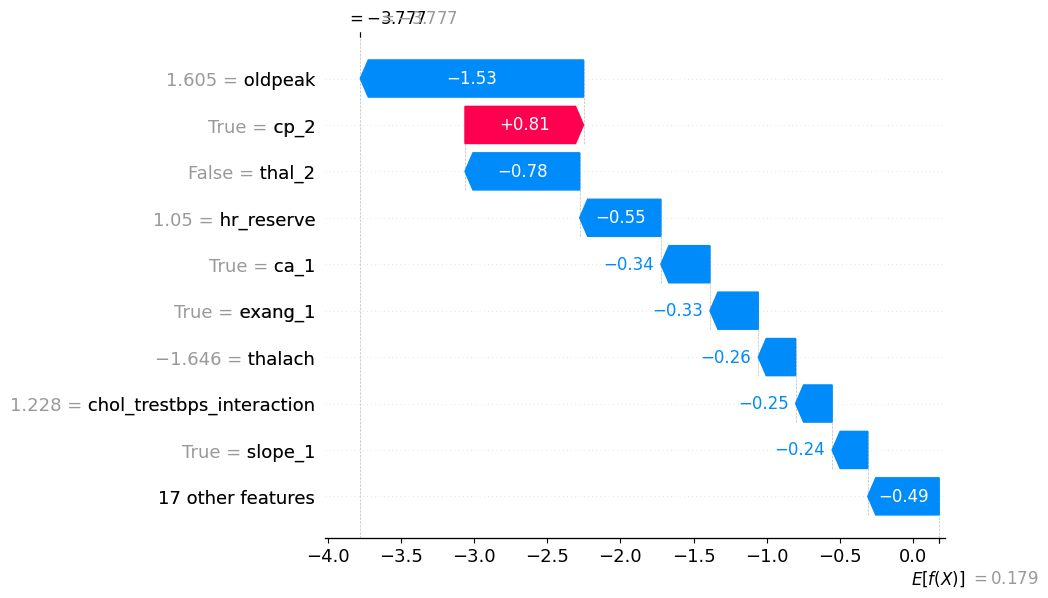


🧠 Responsible AI Interpretation for XGBoost Prediction
Patient Index: 5

📈 Model Base Value (expected prediction): 0.179
📉 Final Prediction Value (after SHAP contributions): -3.777

🔍 Key Feature Influences (Top Contributors):
• oldpeak = 1.605 → ⬇️ decreases risk by 1.526
• cp_2 = 1.000 → ⬆️ increases risk by 0.810
• thal_2 = 0.000 → ⬇️ decreases risk by 0.784
• hr_reserve = 1.050 → ⬇️ decreases risk by 0.555
• ca_1 = 1.000 → ⬇️ decreases risk by 0.335
• exang_1 = 1.000 → ⬇️ decreases risk by 0.330
• thalach = -1.646 → ⬇️ decreases risk by 0.255
• chol_trestbps_interaction = 1.228 → ⬇️ decreases risk by 0.250
• slope_1 = 1.000 → ⬇️ decreases risk by 0.243
• thal_3 = 1.000 → ⬇️ decreases risk by 0.232

✅ Interpretation complete. Use this to explain the model's decision to stakeholders.


In [36]:
# ✅ Step 2: Select the sample index to explain
sample_idx = 5

# ✅ Step 3: Show SHAP Waterfall Plot
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test_df.iloc[sample_idx],
        feature_names=X_test_df.columns.tolist()
    ),
    max_display=10
)

# ✅ Step 4: Interpret SHAP output in human-readable format
def interpret_shap_waterfall(sample_idx, shap_values, explainer, X_test_df, model_name="XGBoost"):
    """
    Prints a human-readable interpretation of a SHAP waterfall plot for a given sample.
    """
    print(f"\n🧠 Responsible AI Interpretation for {model_name} Prediction")
    print(f"Patient Index: {sample_idx}")

    base_value = explainer.expected_value
    final_value = base_value + shap_values[sample_idx].sum()

    print(f"\n📈 Model Base Value (expected prediction): {base_value:.3f}")
    print(f"📉 Final Prediction Value (after SHAP contributions): {final_value:.3f}")

    if isinstance(final_value, np.ndarray):  # for multiclass models
        final_value = final_value[0]

    print("\n🔍 Key Feature Influences (Top Contributors):")

    top_n = 10
    feature_names = X_test_df.columns.tolist()
    sample_shap = shap_values[sample_idx]
    feature_values = X_test_df.iloc[sample_idx].values

    shap_contributions = list(zip(feature_names, feature_values, sample_shap))
    shap_contributions.sort(key=lambda x: abs(x[2]), reverse=True)

    for name, val, shap_val in shap_contributions[:top_n]:
        direction = "⬆️ increases" if shap_val > 0 else "⬇️ decreases"
        print(f"• {name} = {val:.3f} → {direction} risk by {abs(shap_val):.3f}")

    print("\n✅ Interpretation complete. Use this to explain the model's decision to stakeholders.")

# ✅ Step 5: Call the interpretation function
interpret_shap_waterfall(
    sample_idx=sample_idx,
    shap_values=shap_values,
    explainer=explainer,
    X_test_df=X_test_df
)